In [3]:
import torch
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, BatchNorm
from collections import defaultdict
import json
import networkx as nx
from torch import nn
import math
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split

In [4]:
embedding = np.load("./ds/v1/graph2vec_embeddings.npy")
labels = np.load("./ds/v1/graph2vec_labels.npy")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
!rm -rf checkpoints results training_history

In [7]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

In [8]:
class NodeClassificationGNN(nn.Module):
    def __init__(self, input_dim, hidden_channel, num_classes, dropout=0.3, activation=nn.LeakyReLU):
        super().__init__()
        self.activation = activation()  # Initialize activation function
        self.conv1 = SAGEConv(input_dim, hidden_channel)
        self.bn1 = BatchNorm(hidden_channel)  # BatchNorm for first layer
        self.conv2 = SAGEConv(hidden_channel, hidden_channel)
        self.bn2 = BatchNorm(hidden_channel)  # BatchNorm for second layer
        self.dropout = nn.Dropout(dropout)
        
        # MLP for final classification
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channel, hidden_channel),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(hidden_channel, num_classes)
        )

    def forward(self, x, edge_index):
        # First convolutional layer with batch normalization and activation
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Second convolutional layer with batch normalization and activation
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)
        
        # Pass through the MLP for final predictions
        x = self.mlp(x)
        return x


In [9]:
def build_similarity_graph(embeddings, threshold):
    num_nodes = embeddings.shape[0]
    similarity_matrix = cosine_similarity(embeddings)

    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, embedding=embeddings[i])

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if similarity_matrix[i, j] >= threshold:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    return G

def convert_to_torch_geometric(graph):
    node_features = np.array([graph.nodes[n]['embedding'] for n in graph.nodes])
    edge_index = np.array(list(graph.edges)).T
    edge_weights = np.array([graph[u][v]['weight'] for u, v in graph.edges])

    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights)

    return data

def split_data(data, labels, train_ratio=0.7, val_ratio=0.2):
    train_idx, temp_idx, train_labels, temp_labels = train_test_split(
        np.arange(len(labels)), labels, test_size=(1 - train_ratio), stratify=labels
    )
    val_size = val_ratio / (1 - train_ratio)
    val_idx, test_idx, val_labels, test_labels = train_test_split(
        temp_idx, temp_labels, test_size=(1 - val_size), stratify=temp_labels
    )
    return train_idx, val_idx, test_idx

def load_best_model(model, threshold, save_path='checkpoints'):
    checkpoint = torch.load(os.path.join(save_path, f'best_model_threshold_{threshold:.2f}.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])
    return checkpoint['best_val_loss']

def save_training_history(history, threshold, save_path='training_history'):
    os.makedirs(save_path, exist_ok=True)
    with open(os.path.join(save_path, f'history_threshold_{threshold:.2f}.json'), 'w') as f:
        json.dump(history, f, indent=4)

In [10]:
def train(optimizer, criterion, model, data, _, threshold, save_path='checkpoints', num_epochs=300):

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                         factor=0.5, patience=10, 
                                                         min_lr=1e-6, verbose=True)
    
    history = defaultdict(list)
    os.makedirs(save_path, exist_ok=True)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        correct = int(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
        train_acc = correct / data.train_mask.sum().item()

        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
            val_pred = val_out.argmax(dim=1)
            val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
            val_acc = val_correct / data.val_mask.sum().item()

        scheduler.step(val_loss)

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, os.path.join(save_path, f'best_model_threshold_{threshold:.2f}.pt'))
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
                  f"Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
    save_training_history(history, threshold)
    
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    return best_val_loss, history


In [11]:
def build_graphs_and_setup_model(embedding, thresholds=[0.15]):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_threshold = None
    best_test_acc = 0
    all_results = {}
    
    for threshold in thresholds:
        print(f"\nTraining with threshold: {threshold}")
        similarity_graph = build_similarity_graph(embedding, threshold=threshold)
        data = convert_to_torch_geometric(similarity_graph)
        data.y = torch.tensor(labels, dtype=torch.long).to(device)

        train_idx, val_idx, test_idx = split_data(data, labels)
        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        val_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        train_mask[train_idx] = True
        val_mask[val_idx] = True
        test_mask[test_idx] = True
        data.train_mask = train_mask
        data.val_mask = val_mask
        data.test_mask = test_mask
        data = data.to(device)
        
        model = NodeClassificationGNN(input_dim=128, hidden_channel=512, num_classes=len(np.unique(labels)), dropout=0.7).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        criterion = torch.nn.CrossEntropyLoss()
        _, history = train(optimizer, criterion, model, data, labels, threshold)
        model.eval()
        with torch.no_grad():
            test_out = model(data.x, data.edge_index)
            test_pred = test_out.argmax(dim=1)
            test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
            test_acc = test_correct / data.test_mask.sum().item()
        print(f"Test Accuracy: {test_acc:.4f}")
        
        all_results[threshold] = {
            'test_accuracy': test_acc,
            'training_history': history
        }
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_threshold = threshold
    
    if not os.path.exists('results'):
        os.makedirs('results')


    with open('results/overall_results.json', 'w') as f:
        json.dump({
            'best_threshold': best_threshold,
            'best_test_accuracy': best_test_acc,
            'all_thresholds_results': {str(k): v for k, v in all_results.items()}
        }, f, indent=4)

    print(f"\nBest Threshold: {best_threshold:.2f}, Best Test Accuracy: {best_test_acc:.4f}")

In [12]:
def build_graphs_and_setup_model_cv(embedding, labels, thresholds=np.arange(0.05, 0.16, 0.01), n_splits=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_threshold = None
    best_avg_test_acc = 0
    all_results = {}

    train_idx, test_idx = train_test_split(
        np.arange(len(labels)), test_size=0.3, stratify=labels, random_state=42
    )

    for threshold in thresholds:
        print(f"\nTraining with threshold: {threshold}")
        similarity_graph = build_similarity_graph(embedding, threshold=threshold)
        data = convert_to_torch_geometric(similarity_graph)
        data.y = torch.tensor(labels, dtype=torch.long).to(device)

        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
        test_mask[test_idx] = True
        data.test_mask = test_mask
        data = data.to(device)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_test_accuracies = []

        for fold, (train_sub_idx, val_idx) in enumerate(skf.split(train_idx, labels[train_idx])):
            print(f"  Fold {fold + 1}/{n_splits}")

            train_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)
            val_mask = torch.zeros(data.num_nodes, dtype=torch.bool).to(device)

            train_mask[train_idx[train_sub_idx]] = True
            val_mask[train_idx[val_idx]] = True

            data.train_mask = train_mask
            data.val_mask = val_mask

            # Model and optimizer
            input_dim = 128
            hidden_channels = 256
            out_ch = len(np.unique(labels))
            model = NodeClassificationGNN(
                input_dim=input_dim, hidden_channel=hidden_channels, num_classes=out_ch, dropout=0.7
            ).to(device)
            print(f"Model: input_dim: {input_dim}, hidden_channels: {hidden_channels}, output_dim: {out_ch}")
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)
            criterion = torch.nn.CrossEntropyLoss()

            _, history = train(optimizer, criterion, model, data, labels, threshold)
            model.eval()

            # Evaluate on the test set
            with torch.no_grad():
                test_out = model(data.x, data.edge_index)
                test_pred = test_out.argmax(dim=1)
                test_correct = int(test_pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
                test_acc = test_correct / data.test_mask.sum().item()

            print(f"Fold Test Accuracy: {test_acc:.4f}")
            fold_test_accuracies.append(test_acc)

        avg_test_acc = sum(fold_test_accuracies) / n_splits
        print(f"  Average Test Accuracy for Threshold {threshold:.2f}: {avg_test_acc:.4f}")

        all_results[threshold] = {
            'avg_test_accuracy': avg_test_acc,
            'test_accuracies': fold_test_accuracies,
        }
        if avg_test_acc > best_avg_test_acc:
            best_avg_test_acc = avg_test_acc
            best_threshold = threshold

    if not os.path.exists('results'):
        os.makedirs('results')

    with open('results/cv_results.json', 'w') as f:
        json.dump({
            'best_threshold': best_threshold,
            'best_avg_test_accuracy': best_avg_test_acc,
            'all_thresholds_results': {str(k): v for k, v in all_results.items()}
        }, f, indent=4)

    print(f"\nBest Threshold: {best_threshold:.2f}, Best Average Test Accuracy: {best_avg_test_acc:.4f}")


In [13]:
build_graphs_and_setup_model_cv(embedding, labels)


Training with threshold: 0.05
  Fold 1/5
Model: input_dim: 128, hidden_channels: 256, output_dim: 13


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7029, Val Loss: 2.5638, Acc: 0.0760, Val Acc: 0.0824
Epoch 10, Loss: 2.4625, Val Loss: 2.4312, Acc: 0.1620, Val Acc: 0.2301
Epoch 20, Loss: 2.1954, Val Loss: 2.1549, Acc: 0.2345, Val Acc: 0.2585
Epoch 30, Loss: 1.9779, Val Loss: 1.8776, Acc: 0.2843, Val Acc: 0.3267
Epoch 40, Loss: 1.7424, Val Loss: 1.6431, Acc: 0.3276, Val Acc: 0.3892
Epoch 50, Loss: 1.5365, Val Loss: 1.4133, Acc: 0.4115, Val Acc: 0.5170
Epoch 60, Loss: 1.3705, Val Loss: 1.2065, Acc: 0.4741, Val Acc: 0.6136
Epoch 70, Loss: 1.2164, Val Loss: 1.0476, Acc: 0.5252, Val Acc: 0.6420
Epoch 80, Loss: 1.0577, Val Loss: 0.9087, Acc: 0.5729, Val Acc: 0.6790
Epoch 90, Loss: 0.9195, Val Loss: 0.7963, Acc: 0.6389, Val Acc: 0.7045
Epoch 100, Loss: 0.8324, Val Loss: 0.7262, Acc: 0.6539, Val Acc: 0.7358
Epoch 110, Loss: 0.7611, Val Loss: 0.6879, Acc: 0.7001, Val Acc: 0.7216
Epoch 120, Loss: 0.6838, Val Loss: 0.6849, Acc: 0.7242, Val Acc: 0.6932
Epoch 130, Loss: 0.6069, Val Loss: 0.6758, Acc: 0.7548, Val Acc: 0.6960
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6915, Val Loss: 2.5605, Acc: 0.0789, Val Acc: 0.1307
Epoch 10, Loss: 2.4484, Val Loss: 2.4194, Acc: 0.1642, Val Acc: 0.2699
Epoch 20, Loss: 2.1891, Val Loss: 2.1221, Acc: 0.2416, Val Acc: 0.3267
Epoch 30, Loss: 1.9610, Val Loss: 1.8672, Acc: 0.2722, Val Acc: 0.3665
Epoch 40, Loss: 1.7113, Val Loss: 1.6149, Acc: 0.3419, Val Acc: 0.4489
Epoch 50, Loss: 1.5178, Val Loss: 1.3790, Acc: 0.4264, Val Acc: 0.5199
Epoch 60, Loss: 1.3552, Val Loss: 1.1692, Acc: 0.4606, Val Acc: 0.6108
Epoch 70, Loss: 1.2034, Val Loss: 1.0129, Acc: 0.5004, Val Acc: 0.6534
Epoch 80, Loss: 1.0260, Val Loss: 0.9002, Acc: 0.5977, Val Acc: 0.6676
Epoch 90, Loss: 0.9208, Val Loss: 0.7788, Acc: 0.6219, Val Acc: 0.7074
Epoch 100, Loss: 0.8300, Val Loss: 0.6969, Acc: 0.6624, Val Acc: 0.7301
Epoch 110, Loss: 0.7484, Val Loss: 0.6927, Acc: 0.7001, Val Acc: 0.7188
Epoch 120, Loss: 0.6762, Val Loss: 0.6325, Acc: 0.7335, Val Acc: 0.7301
Epoch 130, Loss: 0.6358, Val Loss: 0.5902, Acc: 0.7470, Val Acc: 0.7528
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6905, Val Loss: 2.5597, Acc: 0.0846, Val Acc: 0.0938
Epoch 10, Loss: 2.4500, Val Loss: 2.4134, Acc: 0.1677, Val Acc: 0.2358
Epoch 20, Loss: 2.1610, Val Loss: 2.1159, Acc: 0.2395, Val Acc: 0.2756
Epoch 30, Loss: 1.9608, Val Loss: 1.8440, Acc: 0.2829, Val Acc: 0.3011
Epoch 40, Loss: 1.7240, Val Loss: 1.6062, Acc: 0.3433, Val Acc: 0.3892
Epoch 50, Loss: 1.5096, Val Loss: 1.4049, Acc: 0.4215, Val Acc: 0.5114
Epoch 60, Loss: 1.3825, Val Loss: 1.2313, Acc: 0.4542, Val Acc: 0.5909
Epoch 70, Loss: 1.2003, Val Loss: 1.0847, Acc: 0.5146, Val Acc: 0.6051
Epoch 80, Loss: 1.0445, Val Loss: 0.9070, Acc: 0.5792, Val Acc: 0.6676
Epoch 90, Loss: 0.9304, Val Loss: 0.7850, Acc: 0.6176, Val Acc: 0.7102
Epoch 100, Loss: 0.8402, Val Loss: 0.7153, Acc: 0.6617, Val Acc: 0.7472
Epoch 110, Loss: 0.7590, Val Loss: 0.7291, Acc: 0.7079, Val Acc: 0.6875
Epoch 120, Loss: 0.6940, Val Loss: 0.6790, Acc: 0.7228, Val Acc: 0.7244
Epoch 130, Loss: 0.6795, Val Loss: 0.6168, Acc: 0.7249, Val Acc: 0.7614
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7083, Val Loss: 2.5606, Acc: 0.0796, Val Acc: 0.0795
Epoch 10, Loss: 2.4668, Val Loss: 2.4355, Acc: 0.1635, Val Acc: 0.2244
Epoch 20, Loss: 2.1704, Val Loss: 2.1115, Acc: 0.2509, Val Acc: 0.3040
Epoch 30, Loss: 1.9256, Val Loss: 1.8313, Acc: 0.2985, Val Acc: 0.3920
Epoch 40, Loss: 1.7010, Val Loss: 1.5863, Acc: 0.3454, Val Acc: 0.4261
Epoch 50, Loss: 1.4740, Val Loss: 1.3457, Acc: 0.4357, Val Acc: 0.5142
Epoch 60, Loss: 1.3183, Val Loss: 1.1339, Acc: 0.4783, Val Acc: 0.6108
Epoch 70, Loss: 1.1529, Val Loss: 0.9713, Acc: 0.5487, Val Acc: 0.6619
Epoch 80, Loss: 1.0036, Val Loss: 0.8409, Acc: 0.5906, Val Acc: 0.6903
Epoch 90, Loss: 0.8727, Val Loss: 0.7459, Acc: 0.6503, Val Acc: 0.7216
Epoch 100, Loss: 0.7743, Val Loss: 0.6779, Acc: 0.7015, Val Acc: 0.7472
Epoch 110, Loss: 0.7397, Val Loss: 0.6440, Acc: 0.7058, Val Acc: 0.7330
Epoch 120, Loss: 0.6964, Val Loss: 0.8976, Acc: 0.7171, Val Acc: 0.6222
Epoch 130, Loss: 0.6183, Val Loss: 0.6586, Acc: 0.7406, Val Acc: 0.7131
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7126, Val Loss: 2.5616, Acc: 0.0796, Val Acc: 0.0881
Epoch 10, Loss: 2.4664, Val Loss: 2.4538, Acc: 0.1464, Val Acc: 0.2528
Epoch 20, Loss: 2.2100, Val Loss: 2.1586, Acc: 0.2154, Val Acc: 0.2983
Epoch 30, Loss: 1.9332, Val Loss: 1.8545, Acc: 0.2836, Val Acc: 0.3608
Epoch 40, Loss: 1.6901, Val Loss: 1.5797, Acc: 0.3483, Val Acc: 0.4489
Epoch 50, Loss: 1.4874, Val Loss: 1.3426, Acc: 0.4222, Val Acc: 0.5256
Epoch 60, Loss: 1.3104, Val Loss: 1.1597, Acc: 0.4869, Val Acc: 0.6108
Epoch 70, Loss: 1.1611, Val Loss: 0.9966, Acc: 0.5380, Val Acc: 0.6449
Epoch 80, Loss: 1.0212, Val Loss: 0.8494, Acc: 0.5828, Val Acc: 0.7102
Epoch 90, Loss: 0.9020, Val Loss: 0.7492, Acc: 0.6333, Val Acc: 0.7131
Epoch 100, Loss: 0.7933, Val Loss: 0.7358, Acc: 0.6851, Val Acc: 0.6989
Epoch 110, Loss: 0.7449, Val Loss: 0.7128, Acc: 0.7001, Val Acc: 0.6875
Epoch 120, Loss: 0.6972, Val Loss: 0.6414, Acc: 0.7122, Val Acc: 0.7415
Epoch 130, Loss: 0.6583, Val Loss: 0.6181, Acc: 0.7399, Val Acc: 0.7472
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.7233, Val Loss: 2.5589, Acc: 0.0725, Val Acc: 0.0795
Epoch 10, Loss: 2.4500, Val Loss: 2.4102, Acc: 0.1564, Val Acc: 0.2756
Epoch 20, Loss: 2.1679, Val Loss: 2.1177, Acc: 0.2431, Val Acc: 0.3466
Epoch 30, Loss: 1.9388, Val Loss: 1.8124, Acc: 0.3063, Val Acc: 0.4233
Epoch 40, Loss: 1.6942, Val Loss: 1.5230, Acc: 0.3554, Val Acc: 0.4830
Epoch 50, Loss: 1.4776, Val Loss: 1.2923, Acc: 0.4271, Val Acc: 0.5483
Epoch 60, Loss: 1.2900, Val Loss: 1.1171, Acc: 0.4726, Val Acc: 0.6165
Epoch 70, Loss: 1.1569, Val Loss: 0.9928, Acc: 0.5487, Val Acc: 0.6420
Epoch 80, Loss: 1.0173, Val Loss: 0.8968, Acc: 0.5977, Val Acc: 0.6761
Epoch 90, Loss: 0.9081, Val Loss: 0.7732, Acc: 0.6276, Val Acc: 0.7102
Epoch 100, Loss: 0.8101, Val Loss: 0.7173, Acc: 0.6844, Val Acc: 0.7358
Epoch 110, Loss: 0.7332, Val Loss: 0.6938, Acc: 0.7058, Val Acc: 0.7216
Epoch 120, Loss: 0.6508, Val Loss: 0.7347, Acc: 0.7406, Val Acc: 0.6790
Epoch 130, Loss: 0.6392, Val Loss: 0.6474, Acc: 0.7477, Val Acc: 0.7358
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6643, Val Loss: 2.5640, Acc: 0.0853, Val Acc: 0.0625
Epoch 10, Loss: 2.4562, Val Loss: 2.4364, Acc: 0.1585, Val Acc: 0.2301
Epoch 20, Loss: 2.1972, Val Loss: 2.1554, Acc: 0.2431, Val Acc: 0.2926
Epoch 30, Loss: 1.9707, Val Loss: 1.8908, Acc: 0.2992, Val Acc: 0.3608
Epoch 40, Loss: 1.7447, Val Loss: 1.6268, Acc: 0.3490, Val Acc: 0.4318
Epoch 50, Loss: 1.5366, Val Loss: 1.3674, Acc: 0.3916, Val Acc: 0.5256
Epoch 60, Loss: 1.3346, Val Loss: 1.1528, Acc: 0.4762, Val Acc: 0.6136
Epoch 70, Loss: 1.1831, Val Loss: 1.0062, Acc: 0.5302, Val Acc: 0.6534
Epoch 80, Loss: 1.0623, Val Loss: 0.8790, Acc: 0.5736, Val Acc: 0.6818
Epoch 90, Loss: 0.9442, Val Loss: 0.7599, Acc: 0.6127, Val Acc: 0.7358
Epoch 100, Loss: 0.8417, Val Loss: 0.6989, Acc: 0.6581, Val Acc: 0.7330
Epoch 110, Loss: 0.7646, Val Loss: 0.6632, Acc: 0.7022, Val Acc: 0.7216
Epoch 120, Loss: 0.6618, Val Loss: 0.6587, Acc: 0.7313, Val Acc: 0.6989
Epoch 130, Loss: 0.5986, Val Loss: 0.6493, Acc: 0.7626, Val Acc: 0.7045
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6803, Val Loss: 2.5608, Acc: 0.0824, Val Acc: 0.0739
Epoch 10, Loss: 2.4905, Val Loss: 2.4435, Acc: 0.1507, Val Acc: 0.2358
Epoch 20, Loss: 2.1983, Val Loss: 2.1601, Acc: 0.2225, Val Acc: 0.3153
Epoch 30, Loss: 1.9460, Val Loss: 1.8691, Acc: 0.2985, Val Acc: 0.3665
Epoch 40, Loss: 1.7074, Val Loss: 1.6062, Acc: 0.3582, Val Acc: 0.4091
Epoch 50, Loss: 1.5124, Val Loss: 1.3545, Acc: 0.4129, Val Acc: 0.4886
Epoch 60, Loss: 1.3204, Val Loss: 1.1697, Acc: 0.4790, Val Acc: 0.5938
Epoch 70, Loss: 1.1817, Val Loss: 1.0307, Acc: 0.5380, Val Acc: 0.6307
Epoch 80, Loss: 1.0539, Val Loss: 0.8941, Acc: 0.5828, Val Acc: 0.6761
Epoch 90, Loss: 0.9199, Val Loss: 0.7829, Acc: 0.6176, Val Acc: 0.7017
Epoch 100, Loss: 0.8320, Val Loss: 0.7197, Acc: 0.6681, Val Acc: 0.7216
Epoch 110, Loss: 0.7567, Val Loss: 0.7091, Acc: 0.6915, Val Acc: 0.6847
Epoch 120, Loss: 0.6969, Val Loss: 0.7015, Acc: 0.7200, Val Acc: 0.6875
Epoch 130, Loss: 0.6651, Val Loss: 0.6571, Acc: 0.7392, Val Acc: 0.7131
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6925, Val Loss: 2.5640, Acc: 0.0704, Val Acc: 0.0597
Epoch 10, Loss: 2.4355, Val Loss: 2.4054, Acc: 0.1663, Val Acc: 0.2358
Epoch 20, Loss: 2.1781, Val Loss: 2.1308, Acc: 0.2303, Val Acc: 0.2614
Epoch 30, Loss: 1.9483, Val Loss: 1.8684, Acc: 0.2871, Val Acc: 0.3182
Epoch 40, Loss: 1.7182, Val Loss: 1.6046, Acc: 0.3305, Val Acc: 0.3949
Epoch 50, Loss: 1.5188, Val Loss: 1.3676, Acc: 0.4172, Val Acc: 0.5312
Epoch 60, Loss: 1.3380, Val Loss: 1.1751, Acc: 0.4598, Val Acc: 0.6335
Epoch 70, Loss: 1.1625, Val Loss: 1.0197, Acc: 0.5494, Val Acc: 0.6648
Epoch 80, Loss: 1.0282, Val Loss: 0.8709, Acc: 0.5977, Val Acc: 0.6903
Epoch 90, Loss: 0.9072, Val Loss: 0.7624, Acc: 0.6503, Val Acc: 0.7216
Epoch 100, Loss: 0.7959, Val Loss: 0.7579, Acc: 0.6709, Val Acc: 0.6903
Epoch 110, Loss: 0.7566, Val Loss: 0.7030, Acc: 0.7043, Val Acc: 0.7244
Epoch 120, Loss: 0.6891, Val Loss: 0.6364, Acc: 0.7249, Val Acc: 0.7557
Epoch 130, Loss: 0.6756, Val Loss: 0.6098, Acc: 0.7285, Val Acc: 0.7614
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6887, Val Loss: 2.5613, Acc: 0.0718, Val Acc: 0.0824
Epoch 10, Loss: 2.4478, Val Loss: 2.4194, Acc: 0.1663, Val Acc: 0.2273
Epoch 20, Loss: 2.1652, Val Loss: 2.1195, Acc: 0.2544, Val Acc: 0.2955
Epoch 30, Loss: 1.9073, Val Loss: 1.8459, Acc: 0.3063, Val Acc: 0.3892
Epoch 40, Loss: 1.7116, Val Loss: 1.5890, Acc: 0.3312, Val Acc: 0.4517
Epoch 50, Loss: 1.5153, Val Loss: 1.3675, Acc: 0.3795, Val Acc: 0.5085
Epoch 60, Loss: 1.3139, Val Loss: 1.1792, Acc: 0.4947, Val Acc: 0.6165
Epoch 70, Loss: 1.1638, Val Loss: 1.0266, Acc: 0.5451, Val Acc: 0.6591
Epoch 80, Loss: 1.0160, Val Loss: 0.8648, Acc: 0.6006, Val Acc: 0.6960
Epoch 90, Loss: 0.8886, Val Loss: 0.7728, Acc: 0.6439, Val Acc: 0.7045
Epoch 100, Loss: 0.8095, Val Loss: 0.7659, Acc: 0.6816, Val Acc: 0.6790
Epoch 110, Loss: 0.7695, Val Loss: 0.7261, Acc: 0.6951, Val Acc: 0.6761
Epoch 120, Loss: 0.6836, Val Loss: 0.6835, Acc: 0.7214, Val Acc: 0.6960
Epoch 130, Loss: 0.5928, Val Loss: 0.6884, Acc: 0.7591, Val Acc: 0.6847
Epo

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0, Loss: 2.6974, Val Loss: 2.5595, Acc: 0.0739, Val Acc: 0.0938
Epoch 10, Loss: 2.4670, Val Loss: 2.4550, Acc: 0.1606, Val Acc: 0.3068
Epoch 20, Loss: 2.2053, Val Loss: 2.1500, Acc: 0.2367, Val Acc: 0.3068
Epoch 30, Loss: 1.9426, Val Loss: 1.8491, Acc: 0.2964, Val Acc: 0.3665
Epoch 40, Loss: 1.6764, Val Loss: 1.5970, Acc: 0.3795, Val Acc: 0.4006
Epoch 50, Loss: 1.4749, Val Loss: 1.3390, Acc: 0.4151, Val Acc: 0.5597
Epoch 60, Loss: 1.3244, Val Loss: 1.1252, Acc: 0.4826, Val Acc: 0.6591
Epoch 70, Loss: 1.1550, Val Loss: 0.9631, Acc: 0.5409, Val Acc: 0.6960
Epoch 80, Loss: 1.0646, Val Loss: 0.8189, Acc: 0.5686, Val Acc: 0.7074
Epoch 90, Loss: 0.8739, Val Loss: 0.7124, Acc: 0.6560, Val Acc: 0.7386
Epoch 100, Loss: 0.8300, Val Loss: 0.6579, Acc: 0.6581, Val Acc: 0.7443
Epoch 110, Loss: 0.6943, Val Loss: 0.6465, Acc: 0.7207, Val Acc: 0.7273
Epoch 120, Loss: 0.6389, Val Loss: 0.6677, Acc: 0.7477, Val Acc: 0.7045
Epoch 130, Loss: 0.6172, Val Loss: 0.5833, Acc: 0.7527, Val Acc: 0.7386
Epo

In [14]:
import json
#Load overall_results.json
with open('results/cv_results.json', 'r') as f:
    results = json.load(f)

best_threshold = results['best_threshold']
best_test_accuracy = results['best_avg_test_accuracy']
all_thresholds_results = results['all_thresholds_results']

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


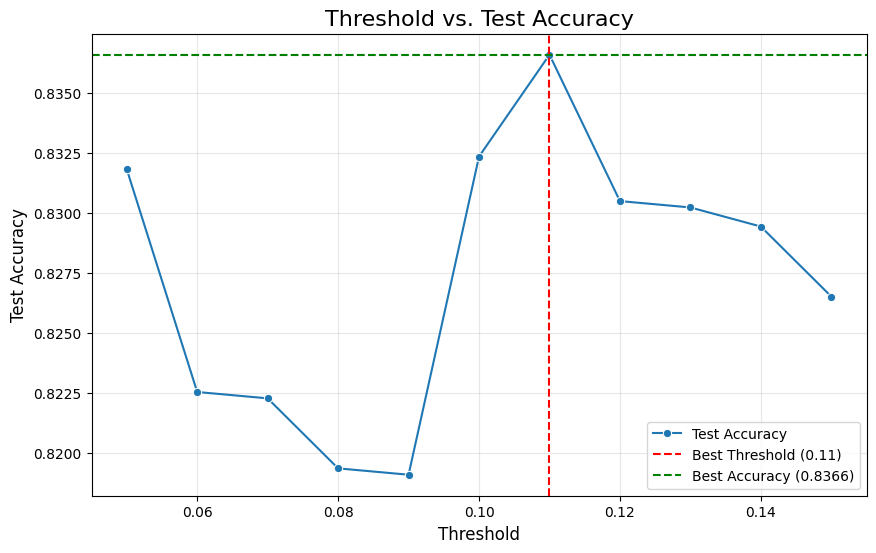

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

thresholds = [float(k) for k in all_thresholds_results.keys()]
test_accuracies = [v['avg_test_accuracy'] for v in all_thresholds_results.values()]
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=test_accuracies, marker="o", label="Test Accuracy")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold ({best_threshold:.2f})")
plt.axhline(best_test_accuracy, color='green', linestyle='--', label=f"Best Accuracy ({best_test_accuracy:.4f})")
plt.title("Threshold vs. Test Accuracy", fontsize=16)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


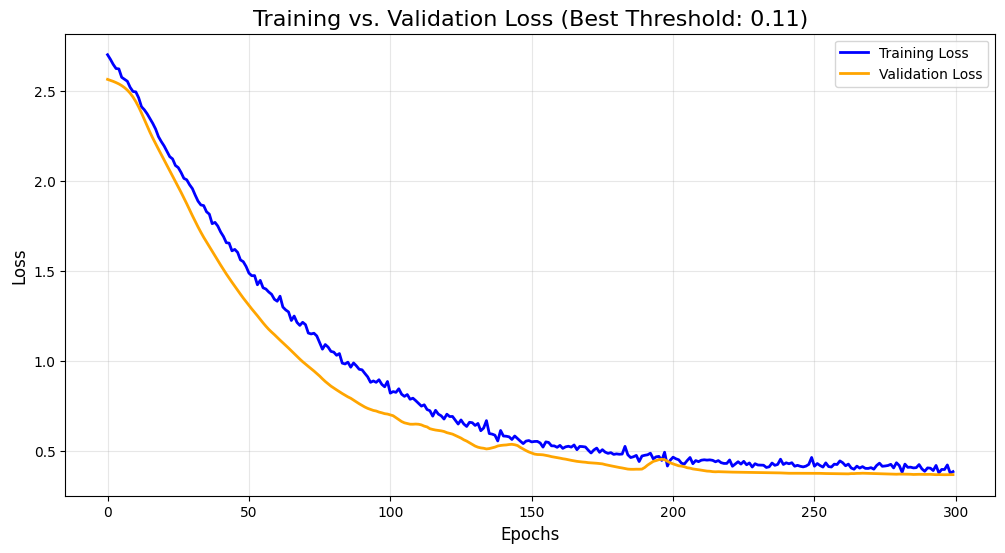

In [16]:

with open(f'training_history/history_threshold_{0.07}.json', 'r') as f:
    best_history = json.load(f)


train_losses = best_history['train_loss']
val_losses = best_history['val_loss']
epochs = range(len(train_losses))
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Training Loss", color='blue', linewidth=2)
plt.plot(epochs, val_losses, label="Validation Loss", color='orange', linewidth=2)
plt.title(f"Training vs. Validation Loss (Best Threshold: {best_threshold:.2f})", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


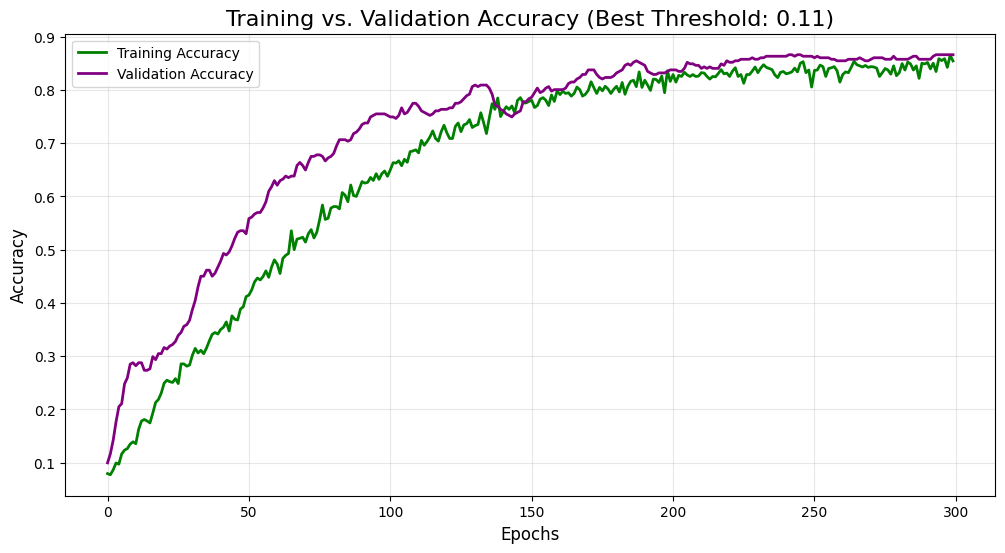

In [17]:
train_acc = best_history['train_acc']
val_acc = best_history['val_acc']
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label="Training Accuracy", color='green', linewidth=2)
plt.plot(epochs, val_acc, label="Validation Accuracy", color='purple', linewidth=2)
plt.title(f"Training vs. Validation Accuracy (Best Threshold: {best_threshold:.2f})", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()


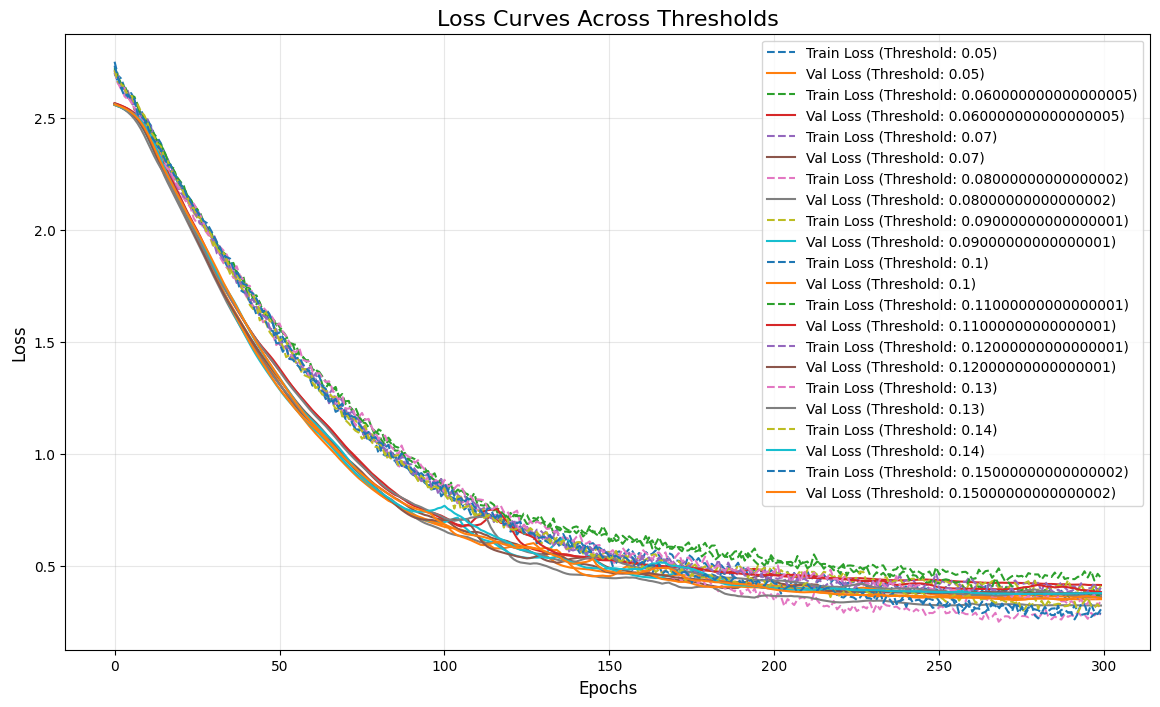

In [24]:
import numpy as np
plt.figure(figsize=(14, 8))

train_info = {}
val_info = {}
for i in np.arange(0.05, 0.16, 0.01):
    # if i != 0.13:
    with open(f'training_history/history_threshold_{i:.2f}.json', 'r') as f:
        best_history = json.load(f)
    train_info[i] = best_history['train_loss']
    val_info[i] = best_history['val_loss']            
    
for (k1, v1), (k2, v2) in zip(train_info.items(), val_info.items()):
    train_loss = v1
    val_loss = v2
    plt.plot(train_loss, label=f"Train Loss (Threshold: {k1})", linestyle='--')
    plt.plot(val_loss, label=f"Val Loss (Threshold: {k1})", linestyle='-')

plt.title("Loss Curves Across Thresholds", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10, loc='upper right')
plt.grid(alpha=0.3)
plt.show()


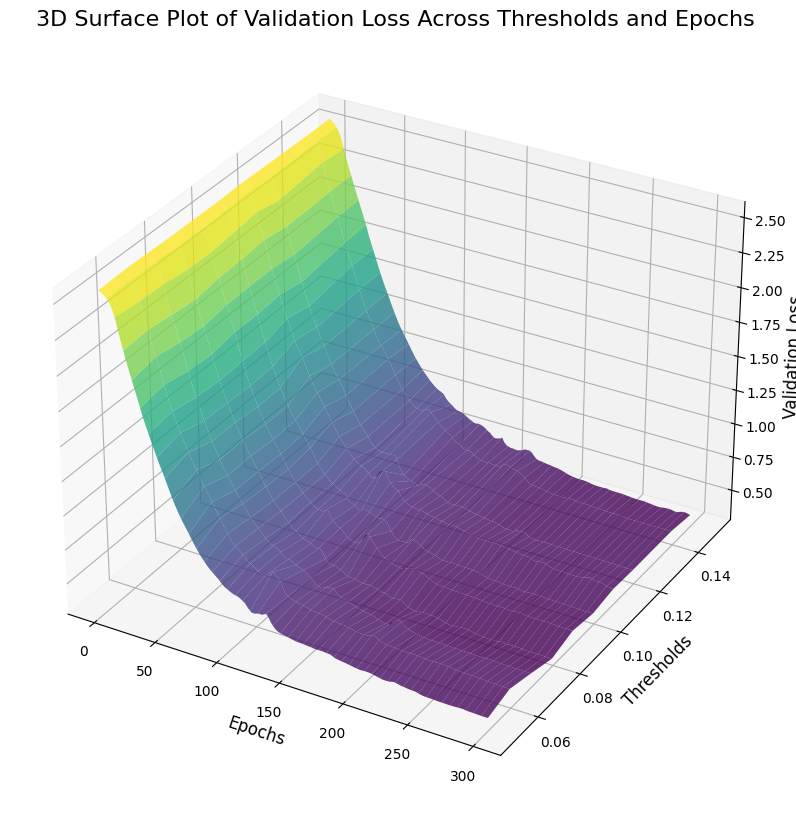

In [21]:
from mpl_toolkits.mplot3d import Axes3D

thresholds = np.array([t for t in thresholds])
epochs = np.arange(len(train_losses))
X, Y = np.meshgrid(epochs, thresholds)
Z = np.array([val_info[threshold] for threshold in thresholds])
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.8)
ax.set_title("3D Surface Plot of Validation Loss Across Thresholds and Epochs", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Thresholds", fontsize=12)
ax.set_zlabel("Validation Loss", fontsize=12)
plt.show()


In [23]:
import shutil
shutil.make_archive('working_dir', 'zip', '/kaggle/working')

'/kaggle/working/working_dir.zip'

In [ ]:
!pip install karateclub